In [6]:
import pandas as pd
import numpy as np
import random

from importlib import reload
import sys

from scipy.stats import poisson, beta, norm
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("dark")

### Plan

1. Plot different parameterized distributions and write method to sample them
2. Write bandit algo testing class
3. Implement ep greedy, UCB, thompson sampling, and gradient descent bandits 
4. Implement policies based on Quantile Regression

### Testing

1. Non-stationary distribution 
2. Iid normal distributions where the sample mean is chosen from N(0, 1)
3. Iid normal distributions where the sample mean is chosen from skewed distribution
4. Skewed distributions where the sample mean is chosen from N(0, 1)
5. Skewed distributions where sample is chosen from skewed distribution
6. Random mix of beta distributions where (a,b) is chosen from abs(N(0,1))

#### Test Distributions

In [3]:
mu = .6
mean = 0
seed = 14

mean, var, skew, kurt = poisson.stats(mu, moments='mvsk')

In [4]:
a, b = .5, 5
dist_one = beta(a = .5, b = 3)
dist_two = beta(a = 10, b = 10)
dist_three = beta(a = 5, b = .5)

In [5]:
dist_one.a = 10

(0.14285714285714285, 0.027210884353741496, 1.5745916432444338, 2.2237762237762237)


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


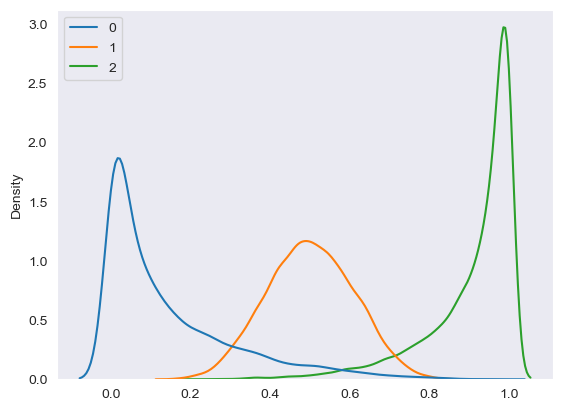

In [6]:
sns.kdeplot(data=[dist_one.rvs(10000), dist_two.rvs(10000), dist_three.rvs(10000)])
print(dist_one.stats(moments='mvsk'))

In [7]:
norm_one = norm(0)

norm_one.stats()

(0.0, 1.0)

#### Test Agents

##### Baseline Tests

In [29]:
#importlib.reload(sys.modules['Baseline.py'])
import TestingSuite, Baseline
reload(Baseline)
reload(TestingSuite)

from TestingSuite import experiment, StationaryBandit, StationaryBandit
from Baseline import SampleAverage, ConstantStepSize, UCB, Gradient

n = 10
iv = 10

agents = [ConstantStepSize(k = n, elipson=.05, alpha = .05), 
          SampleAverage(k = n, elipson=.05), 
          Gradient(alpha = .1, k = n), 
          UCB(c_value=.75, k = n)]

opt_agents = [ConstantStepSize(k = n, elipson=.05, alpha = .05, init_value = iv), 
              SampleAverage(k = n, elipson=.05, init_value = iv), 
              Gradient(alpha = .1, k = n, init_value =  iv), 
              UCB(c_value=.75, k = n, init_value = iv)]

In [30]:
norm_bandit = StationaryBandit(k = n, arm_dist=norm(0, 1), sample_dist=norm)

In [31]:
results = experiment(bandit = norm_bandit, agents = agents,
                     bandit_runs = 10, steps = 10000)

Agent ConstantStepSize
1.6250207075449095 0.8
Agent SampleAverage
2.8669943928505672 0.8
Agent Gradient
1.8954370600392862 0.2
Agent UCB
2.221092779961192 0.3


In [32]:
results = experiment(bandit = norm_bandit, agents = agents,
                     bandit_runs = 300, steps = 10000)

Agent ConstantStepSize
2.4192001244844037 0.8466666666666667
Agent SampleAverage
2.4629002184547053 0.89
Agent Gradient
1.0570350644567212 0.11333333333333333
Agent UCB
1.718941648828688 0.19666666666666666


In [33]:
opt_results = experiment(bandit = norm_bandit, agents = opt_agents,
                         bandit_runs = 300, steps = 10000)

Agent ConstantStepSize
2.5474651225970693 0.8933333333333333
Agent SampleAverage
2.528887921288868 0.9166666666666666
Agent Gradient
0.9346615218811962 0.12666666666666668
Agent UCB
2.4896712864959554 0.97


In [385]:
opt_skew_results = experiment(bandit = skew_bandit, agents = opt_agents,
                              bandit_runs = 100, steps = 2500)

Agent ConstantStepSize
0.6598818296370109 0.93
Agent SampleAverage
0.6689698818608026 0.95
Agent Gradient
-0.5909999465937498 0.16
Agent UCB
0.6842496043665863 0.96


In [392]:
skew_results = experiment(bandit = skew_bandit, agents = agents,
                          bandit_runs = 100, steps = 2500)

Agent ConstantStepSize
0.6290731414833792 0.81
Agent SampleAverage
0.5954485366109101 0.92
Agent Gradient
-0.7549250987873067 0.14
Agent UCB
0.8910534925597291 0.81


In [356]:
def get_df(results):
    stats = ['Average Reward', '% Optimal Action']
    df = pd.DataFrame(results, index = stats)

    df = df.explode(column=list(df.columns))
    df.index = [df.index, df.groupby(df.index).cumcount()]

    return df

In [34]:
df = get_df(results)
opt_df = get_df(opt_results)

opt_df.loc['% Optimal Action'].plot(title = 'Optimal Action')
opt_df.loc['% Optimal Action'].plot(title = 'Average Reward')

NameError: name 'get_df' is not defined

<Axes: title={'center': 'Average Reward'}>

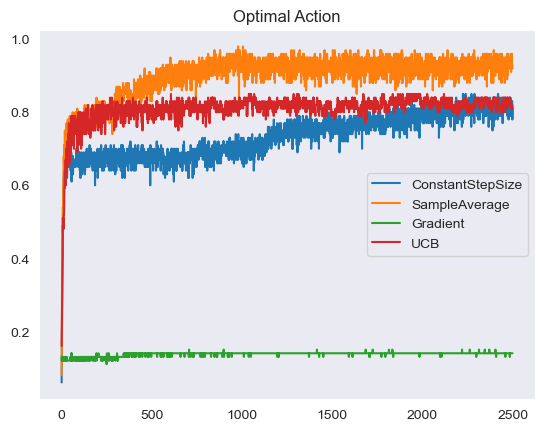

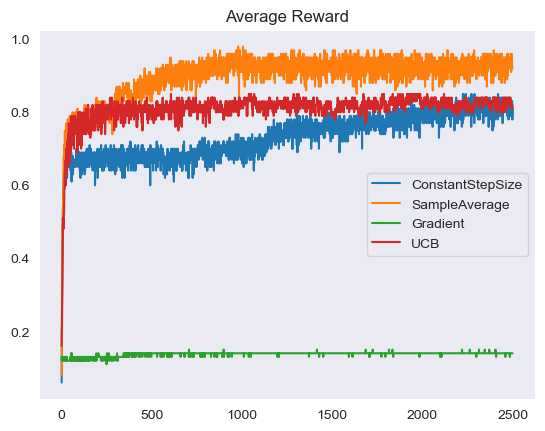

In [393]:
opt_skew_df = get_df(skew_results)

opt_skew_df.loc['% Optimal Action'].plot(title = 'Optimal Action')
opt_skew_df.loc['% Optimal Action'].plot(title = 'Average Reward')

### Quantile Regression

In [522]:
importlib.reload(sys.modules['QrAgents'])
importlib.reload(sys.modules['TestingSuite'])

from QrAgents import QRAgent, BiasedQRAgent, BonusQRAgent, MultiQRAgent
from TestingSuite import experiment, StationaryBandit, StationaryBandit

In [359]:
norm_bandit = StationaryBandit(arm_dist = norm(0, 1), sample_dist = norm(0, 1))

<Axes: ylabel='Density'>

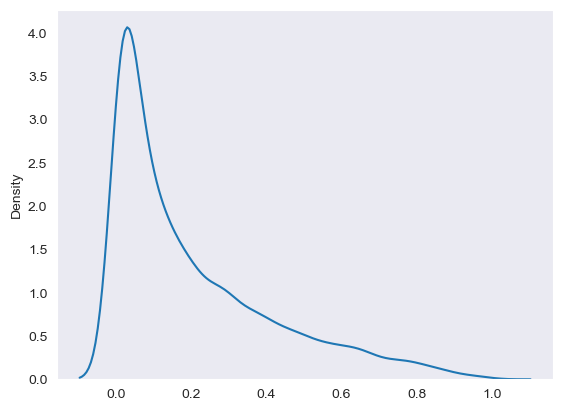

In [360]:
skew_bandit = StationaryBandit(arm_dist = norm(-1, 1), scale = 1, sample_dist = beta(a = .5, b = 2))

rewards = [skew_bandit.step(skew_bandit.best()) for _ in range(10000)]
sns.kdeplot(rewards)

#### Test Quantile Regression Algorithm

In [7]:
def reg_weights(agent, data):
    agent.reset()
    for r in data: agent.update(0, r)
    return agent.get_weights()[0]

In [8]:
test_QR = QRAgent(k = 16, alpha = .05)

dist_one = beta(a = .5, b = 5)
dist_two = beta(a = 10, b = 10)
dist_three = beta(a = 5, b = .5)

walk_len = 10000
walk_one = dist_one.rvs(walk_len)
weights = reg_weights(test_QR, walk_one)

NameError: name 'QRAgent' is not defined

In [9]:
dist_one = beta(.5, 5)

In [364]:
weights = test_QR.get_weights()[0]
weights

array([-0.0375, -0.0125,  0.0125,  0.0375,  0.0125,  0.0375,  0.0625,
        0.0375,  0.0625,  0.0375,  0.0625,  0.0375,  0.0625,  0.0875,
        0.0625,  0.0875,  0.0625,  0.0875,  0.1125,  0.1375,  0.1625,
        0.1375,  0.1625,  0.1875,  0.2125,  0.2375,  0.2625,  0.2875,
        0.3125,  0.3375,  0.3125,  0.4375])

<Axes: ylabel='Density'>

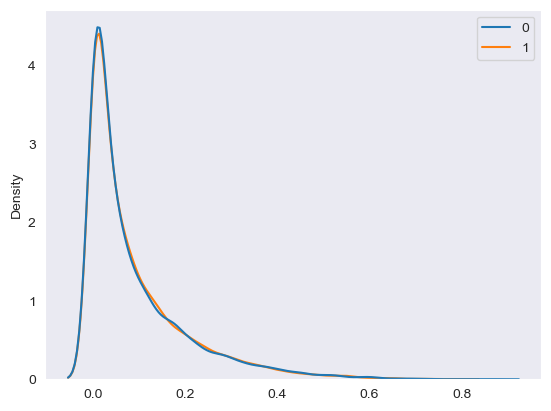

In [365]:
sns.kdeplot(data = [walk_one, dist_one.rvs(10000)])

#### Quantile Regression Experiments

In [523]:
n = 10
iv = 10

qr_agents = [QRAgent(k=n, epsilon=.05),
             QRAgent(k=n, epsilon=.1),
             QRAgent(k=n, alpha = .1, epsilon=.05),
             QRAgent(k=n, alpha = .1, epsilon=.1)]

qr_agents = [QRAgent(k=n),
             QRAgent(k=n, n = 16),
             QRAgent(k=n, n = 8),
             QRAgent(k=n, n = 4)]

biased_qr_agents = [BiasedQRAgent(k=n, decay_factor = .9, n = 16),
                    BiasedQRAgent(k=n, decay_factor = -0.9, n = 16),
                    BiasedQRAgent(k=n, decay_factor = .5, n = 16),
                    BiasedQRAgent(k=n, decay_factor = 1, n = 16)]

biased_decay_qr_agents = [BiasedQRAgent(k=n, decay_factor = .9, norm_factor = .0, n = 16),
                          BiasedQRAgent(k=n, decay_factor = .9, norm_factor = .01, n = 16),
                          BiasedQRAgent(k=n, decay_factor = .9, norm_factor = .05, n = 16),
                          BiasedQRAgent(k=n, decay_factor = .5, norm_factor = .0, n = 16),
                          BiasedQRAgent(k=n, decay_factor = .5, norm_factor = .01, n = 16),
                          BiasedQRAgent(k=n, decay_factor = .5, norm_factor = .05, n = 16),]

high_bias_decay_qr_agents = [BiasedQRAgent(k=n, decay_factor = .25, norm_factor = .03, n = 16),
                             BiasedQRAgent(k=n, decay_factor = .5, norm_factor = .01, n = 16),
                             BiasedQRAgent(k=n, epsilon=.025, decay_factor = .5, norm_factor = .05, n = 16),]

multi_qr_agents = [MultiQRAgent(k=n, estimators = 11, n = 16),
                  MultiQRAgent(k=n, estimators = 5, n = 16),
                  MultiQRAgent(k=n, estimators = 11, norm_factor = .025, n = 16),
                  MultiQRAgent(k=n, estimators = 5, norm_factor = .025, n = 16),]

ex_qr_agents = [BonusQRAgent(k=n, init_c = 10., n = 16),
                BonusQRAgent(k=n, init_c = 5., n = 16),
                BonusQRAgent(k=n, init_c = 1., n = 16),
                BonusQRAgent(k=n, init_c = .5, n = 16)]

biased_softmax_qr_agents = [BiasedQRAgent(k=n, decay_factor = .9, softmax = True, n = 16),
                    BiasedQRAgent(k=n, decay_factor = -0.9, softmax = True, n = 16),
                    BiasedQRAgent(k=n, decay_factor = .5, softmax = True, n = 16)]

10.0
5.0
1.0
0.5


In [367]:
qr_results = experiment(bandit = norm_bandit, agents = qr_agents,
                        bandit_runs = 300, steps = 40000)
"""
Agent QRAgent (e:0.05, n:32, alpha:0.1, batch_update:False)
1.4189338447942195 0.89
Agent QRAgent (e:0.05, n:16, alpha:0.1, batch_update:False)
1.3835695173313505 0.8633333333333333
Agent QRAgent (e:0.05, n:8, alpha:0.1, batch_update:False)
1.3433036371551301 0.8366666666666667
Agent QRAgent (e:0.05, n:4, alpha:0.1, batch_update:False)
1.448204077832645 0.8833333333333333
"""

biased_qr_results = experiment(bandit = norm_bandit, agents = biased_qr_agents,
                               bandit_runs = 300, steps = 40000)
"""
Agent Biased QRAgent (e:0.1, n:16, decay: 0.9, alpha:0.05, batch_update:False)
1.4099804219162557 0.8933333333333333
Agent Biased QRAgent (e:0.1, n:16, decay: -0.9, alpha:0.05, batch_update:False)
1.3816278435153664 0.83
Agent Biased QRAgent (e:0.1, n:16, decay: 0.5, alpha:0.05, batch_update:False)
1.3839881033272172 0.8966666666666666
Agent Biased QRAgent (e:0.1, n:16, decay: 1, alpha:0.05, batch_update:False)
1.28112487307114 0.8333333333333334
"""

biased_softmax_qr_results = experiment(bandit = norm_bandit, agents = biased_softmax_qr_agents,
                                       bandit_runs = 300, steps = 40000)
"""
Agent Biased QRAgent (e:0.1, n:16, decay: 0.9, alpha:0.05, batch_update:False)
0.23343031864273117 0.1
Agent Biased QRAgent (e:0.1, n:16, decay: -0.9, alpha:0.05, batch_update:False)
-0.756989224325067 0.1
Agent Biased QRAgent (e:0.1, n:16, decay: 0.5, alpha:0.05, batch_update:False)
-0.11382904787676282 0.3
"""

explore_qr_results = experiment(bandit = norm_bandit, agents = ex_qr_agents,
                                bandit_runs = 300, steps = 40000)
"""
Agent Exploration Bonus QRAgent (e:0.1, n:16, c_value: 0.75, alpha:0.05, batch_update:False)
-0.0008429792564097802 0.12
Agent Exploration Bonus QRAgent (e:0.05, n:16, c_value: 0.75, alpha:0.05, batch_update:False)
-0.09744198841124595 0.12
"""

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/bhartipatel/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/ph/bvvn8rqj6bjd_xbgv6f71vnc0000gn/T/ipykernel_49399/390319469.py", line 1, in <module>
    qr_results = experiment(bandit = norm_bandit, agents = qr_agents,
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/bhartipatel/Desktop/Thesis/Bandit Sims/TestingSuite.py", line 95, in experiment
    rs, best_action_taken = run_episode(bandit, algo, steps)
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/bhartipatel/Desktop/Thesis/Bandit Sims/TestingSuite.py", line 79, in run_episode
    algorithm.update(a, r)
  File "/Users/bhartipatel/Desktop/Thesis/Bandit Sims/QrAgents.py", line 35, in update
    else: self._update_q(a, r)
          ^^^^^^^^^^^^^^^^^^^^
  File "/Users/bhartipatel/Desktop/Thesis/Bandit S

<Axes: ylabel='Density'>

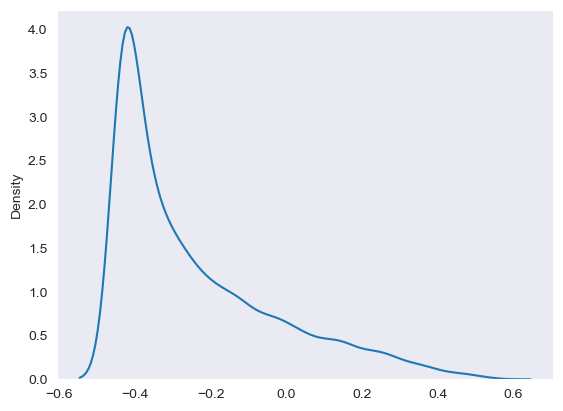

In [376]:
skew_bandit = StationaryBandit(arm_dist = norm(-1, 1), scale = 1, sample_dist = beta(a = .5, b = 2))

rewards = [skew_bandit.step(skew_bandit.best()) for _ in range(10000)]
sns.kdeplot(rewards)

In [ ]:
left_skew_bandit = StationaryBandit(arm_dist = norm(-1, 1), scale = 1, sample_dist = beta(a = .5, b = 2))

rewards = [skew_bandit.step(skew_bandit.best()) for _ in range(10000)]
sns.kdeplot(rewards)

In [370]:
rewards = []

for a in range(10):
    r = []
    for b in range(1000):
        r.append(skew_bandit.step(skew_bandit.best()))
    skew_bandit.reset()
    rewards += r

#pd.DataFrame(rewards).plot()

In [438]:
skew_results = experiment(bandit = skew_bandit, agents = qr_agents,
                          bandit_runs = 10, steps = 2500)

Agent QRAgent (e:0.05, n:32, alpha:0.1, batch_update:False)
0.7734777741654499 1.0
Agent QRAgent (e:0.05, n:16, alpha:0.1, batch_update:False)
0.6333666541855392 0.7
Agent QRAgent (e:0.05, n:8, alpha:0.1, batch_update:False)
0.6797306554771192 1.0
Agent QRAgent (e:0.05, n:4, alpha:0.1, batch_update:False)
1.1909639215103385 1.0


In [478]:
biased_skew_results = experiment(bandit = skew_bandit, agents = biased_qr_agents,
                                 bandit_runs = 100, steps = 2500)

Agent Biased QRAgent (e:0.05, n:16, decay: 0.9, alpha:0.05, batch_update:False)
0.500088828055031 0.79
Agent Biased QRAgent (e:0.05, n:16, decay: -0.9, alpha:0.05, batch_update:False)
0.6168045766998608 0.72
Agent Biased QRAgent (e:0.05, n:16, decay: 0.5, alpha:0.05, batch_update:False)
0.6158242153442273 0.74
Agent Biased QRAgent (e:0.05, n:16, decay: 1, alpha:0.05, batch_update:False)
0.6506461579877246 0.81


In [491]:
biased_decay_skew_results = experiment(bandit = skew_bandit, agents = biased_decay_qr_agents,
                                       bandit_runs = 100, steps = 3000)

Agent Biased QRAgent (e:0.05, n:16, decay: 0.9, norm_factor: 0.0, alpha:0.05, batch_update:False)
0.6387362610307971 0.73
Agent Biased QRAgent (e:0.05, n:16, decay: 0.9, norm_factor: 0.01, alpha:0.05, batch_update:False)
0.5488730676878525 0.8
Agent Biased QRAgent (e:0.05, n:16, decay: 0.9, norm_factor: 0.05, alpha:0.05, batch_update:False)
0.6999418278861833 0.78
Agent Biased QRAgent (e:0.05, n:16, decay: 0.5, norm_factor: 0.0, alpha:0.05, batch_update:False)
0.5710456663520229 0.62
Agent Biased QRAgent (e:0.05, n:16, decay: 0.5, norm_factor: 0.01, alpha:0.05, batch_update:False)
0.5898742096436826 0.82
Agent Biased QRAgent (e:0.05, n:16, decay: 0.5, norm_factor: 0.05, alpha:0.05, batch_update:False)
0.5686210382272718 0.77


In [507]:
high_bias_decay_skew_results = experiment(bandit = skew_bandit, agents = high_bias_decay_qr_agents,
                                          bandit_runs = 100, steps = 7500)

Agent Biased QRAgent (e:0.05, n:16, decay: 0.25, norm_factor: 0.03, alpha:0.05, batch_update:False)
0.706635389729202 0.91
Agent Biased QRAgent (e:0.05, n:16, decay: 0.5, norm_factor: 0.01, alpha:0.05, batch_update:False)
0.5440903104954542 0.86
Agent Biased QRAgent (e:0.025, n:16, decay: 0.5, norm_factor: 0.05, alpha:0.05, batch_update:False)
0.5685022748414013 0.91


In [494]:
ex_skew_results = experiment(bandit = skew_bandit, agents = ex_qr_agents,
                             bandit_runs = 100, steps = 3000)

Agent Exploration Bonus QRAgent (e:0.05, n:16, c_value: 10.0, alpha:0.05, batch_update:False)
0.6251582359816458 0.76
Agent Exploration Bonus QRAgent (e:0.05, n:16, c_value: 5.0, alpha:0.05, batch_update:False)
0.5285220335637763 0.71
Agent Exploration Bonus QRAgent (e:0.05, n:16, c_value: 1.0, alpha:0.05, batch_update:False)
0.49150951249324115 0.73
Agent Exploration Bonus QRAgent (e:0.05, n:16, c_value: 0.5, alpha:0.05, batch_update:False)
0.6100320906912828 0.77


In [524]:
multi_qr_agent = experiment(bandit = skew_bandit, agents = multi_qr_agents,
                             bandit_runs = 10, steps = 7500)

Agent Multi QRAgent (e:0.05, n:16, estimators: 11, norm_factor: 0, alpha:0.05)
-0.8095756718829262 0.2
Agent Multi QRAgent (e:0.05, n:16, estimators: 5, norm_factor: 0, alpha:0.05)
-1.3938284581061544 0.0
Agent Multi QRAgent (e:0.05, n:16, estimators: 11, norm_factor: 0.025, alpha:0.05)
-0.8860752297921571 0.2
Agent Multi QRAgent (e:0.05, n:16, estimators: 5, norm_factor: 0.025, alpha:0.05)
-0.9392349712474983 0.0


<Axes: title={'center': 'Average Reward'}>

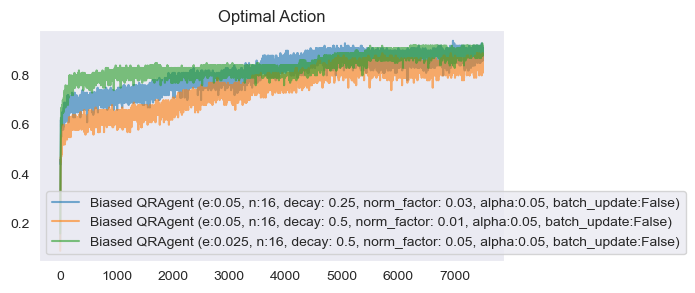

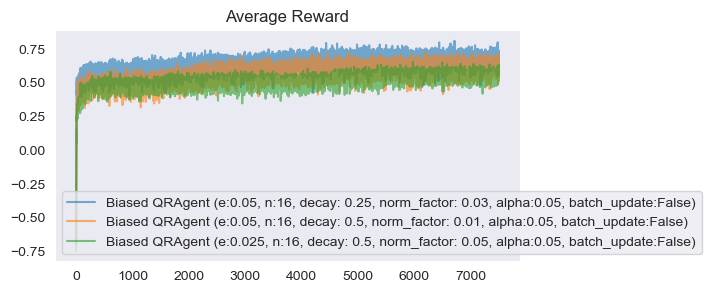

In [508]:
qr_df = get_df(high_bias_decay_skew_results)

qr_df.loc['% Optimal Action'].plot(title = 'Optimal Action', figsize = (6, 3), alpha=0.6)  
qr_df.loc['Average Reward'].plot(title = 'Average Reward', figsize = (6, 3), alpha=0.6)

#### Scratch Work

In [4]:
n = 2
a = np.full(n, 1./n).cumsum() - np.full(n, 1/(n * 2))
a

array([0.25, 0.75])

In [411]:
n = 5
decay = 1
scale = (1 - decay)/(1 - pow(decay, n)) if decay != 1 else 1./n

w = np.full(n, decay).cumprod() * 1./decay * scale
print(w, w.sum())

[0.2 0.2 0.2 0.2 0.2] 1.0


In [462]:
decay = 1.05
np.full(n, decay).cumprod() * .9

array([0.945     , 0.99225   , 1.0418625 , 1.09395563, 1.14865341,
       1.20608608, 1.26639038, 1.3297099 , 1.39619539, 1.46600516])

In [10]:
from sympy import *

def get_cpw_weights(q, B = .73):
    t = Symbol('t')
    y = pow(t, B)/pow((pow(t, B) + pow(1 - t, B)), 1/B)
    y_prime = y.diff(t)
    display(y_prime)

    f = lambdify(t, y_prime, 'numpy')
    return f(q)/f(q).sum()

def get_exp_weights(q, rate):
    t = Symbol('t')
    y = rate * pow(np.e, -rate * t)
    display(y)

    f = lambdify(t, y, 'numpy')
    ones = np.ones(len(q)).cumsum()
    return f(ones)/f(ones).sum()

In [19]:
n = 8
q = np.full(n, 1./n).cumsum() - np.full(n, 1./(n * 2))
get_cpw_weights(q, B = .6)

0.6/(t**0.4*(t**0.6 + (1 - t)**0.6)**1.66666666666667) + t**0.6*(-1.0/t**0.4 + 1.0/(1 - t)**0.4)/(t**0.6 + (1 - t)**0.6)**2.66666666666667

array([0.17717807, 0.09537002, 0.07717533, 0.07359108, 0.07865648,
       0.09400468, 0.13139615, 0.2726282 ])

-0.1*2.71828182845905**(0.1*t)

<Axes: xlabel='Tau', ylabel='Weight'>

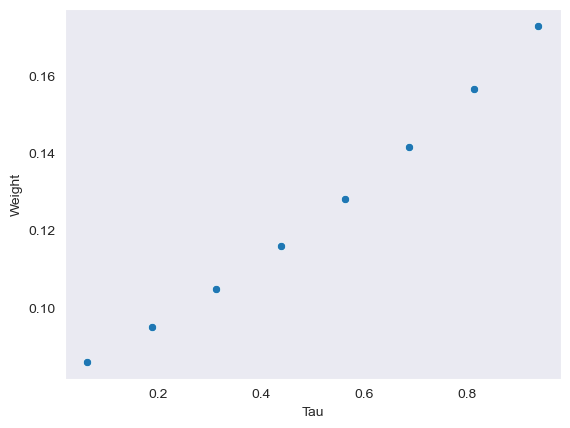

In [30]:
w = get_exp_weights(q, rate = -.15)
pd_w = pd.DataFrame(data = [q, w], index = ['Tau', 'Weight']).T
sns.scatterplot(pd_w, x = 'Tau', y = 'Weight')

In [66]:
tau, B = .1, .99

t = Symbol('t')
y = pow(t, B)/pow((pow(t, B) + pow(1 - t, B)), 1/B)
y_prime = y.diff(t)
f = lambdify(t, y_prime, 'numpy')

In [71]:
display(y_prime)

0.99/(t**0.01*(t**0.99 + (1 - t)**0.99)**1.01010101010101) + t**0.99*(-1.0/t**0.01 + 1.0/(1 - t)**0.01)/(t**0.99 + (1 - t)**0.99)**2.01010101010101

In [68]:
f(q)

array([1.01365299, 0.99900502, 0.99283104, 0.99022994, 0.99025507,
       0.99291   , 0.99915232, 1.01392702])